In [24]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from tqdm import tqdm
from nltk.corpus import stopwords
stopwordEn = stopwords.words('english')
import pickle

In [4]:
# get news data example:(0328) 
with open('df_0328_news.pickle', 'rb') as handle:
    df = pickle.load(handle)

In [5]:
df.head()

,published,text
0,2020-03-28T00:00:00.000+03:00,+3\nMORE GALLERIES\nA DIGITAL album release su...
1,2020-03-28T00:00:00.000+03:00,The provincial plan includes $7 billion in add...
2,2020-03-28T00:00:00.000+03:00,Mark Forums Read Welcome to the Forums at Psyc...
3,2020-03-28T00:00:00.000+03:00,Former Wales international Simon Church was st...
4,2020-03-28T00:00:00.000+03:00,The Tokyo Postponement in Perspective: What Ha...


# Pos tagging

In [ ]:
df.loc[:,'pos'] = [[i[1] for i in nltk.pos_tag(word_tokenize(s))] for s in df['text']]
df.head()

In [9]:
df.shape

(50665, 2)

In [10]:
# with open('df_11_full_text.pickle','wb') as handle:
#      pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [163]:
# Graph-based FP mining edges即为共现序列
def buildEdges(df, k=2, minS=10, raw=False, unique=False, pos=True):  
# l为输入的序列集合， k是序列中行为的个数 默认为2，minS是最小支持度 默认为10, 若raw为真返回原始全部dict数据
  edges = {}
  for r in range(len(df)):
    s = df.pos[r] if pos else word_tokenize(df.text[r])
    s=s[:]
    s.insert(0,'s') # start notation
    for i in range(len(s)):
      if i+ k <= len(s):
        edge = '-'.join(s[i:i+k]) 
        c = df.counts[r] if unique==False else 1
        if edge in edges:
          edges[edge] += c
        else:
          edges[edge] = c
  
  df_edges = pd.DataFrame(edges,index=['Support']).T.sort_values(by=['Support'],ascending=False)
  stat = {'TotalCombinations':len(df_edges),'min':df_edges['Support'].min(),
          'median':df_edges['Support'].median(),'mean':df_edges['Support'].mean(),
          'max':df_edges['Support'].max()
         }
  return df_edges[df_edges['Support']>minS],pd.DataFrame([stat]) if raw==False else edges
# 输出为tuple, [0]项为dataframe结果，[1]为全部组合的统计数据

In [144]:
buildEdges(df,5,5000)[0]

,Support
NNP-NNP-NNP-NNP-NNP,12332
s-NNP-NNP-NNP-:,6313


In [ ]:
buildEdges(df,2,1500,pos=False)[0]

# Word Frequency

In [11]:
all_words = []
for text in tqdm(df.text):
    tokens = word_tokenize(text)
    all_words.extend([i for i in tokens if i not in stopwordEn and i.isalpha()])

100%|██████████| 50665/50665 [08:33<00:00, 98.68it/s] 


## Multiprocessing

In [ ]:
import multiprocessing as mp
import numpy as np
import time
print('CPU numbers:',mp.cpu_count())
def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
#     print(kwargs)
    workers = kwargs.pop('workers')
    pool = mp.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))
#apply_by_multiprocessing(fullset['Text'], process_text, workers=cores)

In [ ]:
#multiprocessing method
def processText(text):
    tokens = word_tokenize(text)
    return [i for i in tokens if i not in stopwordEn and i.isalpha()]

all_words = []
s_py = time.time()
for i in apply_by_multiprocessing(df['text'], processText, workers=32):
    all_words.extend(i)
print("programme:",time.time()-s_py)

In [11]:
len(all_words)

15122061

In [12]:
words_dict = nltk.FreqDist(all_words)
len(words_dict)

215075

# Word clouds

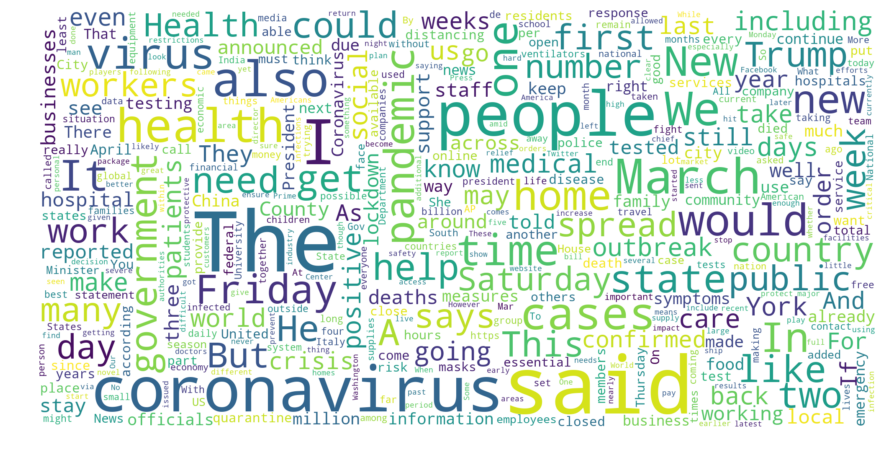

In [13]:
# tags cloud (with retweets)
# https://www.datacamp.com/community/tutorials/wordcloud-python
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# % matplotlib inline

wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=18, max_words=1000, background_color="white").generate_from_frequencies(words_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [14]:
words_dict.most_common(15)

[('The', 181529),
 ('said', 162835),
 ('coronavirus', 94976),
 ('I', 94423),
 ('people', 90185),
 ('also', 53177),
 ('March', 52091),
 ('We', 48498),
 ('health', 47846),
 ('cases', 46489),
 ('would', 42623),
 ('one', 41933),
 ('virus', 41667),
 ('time', 41392),
 ('It', 40872)]

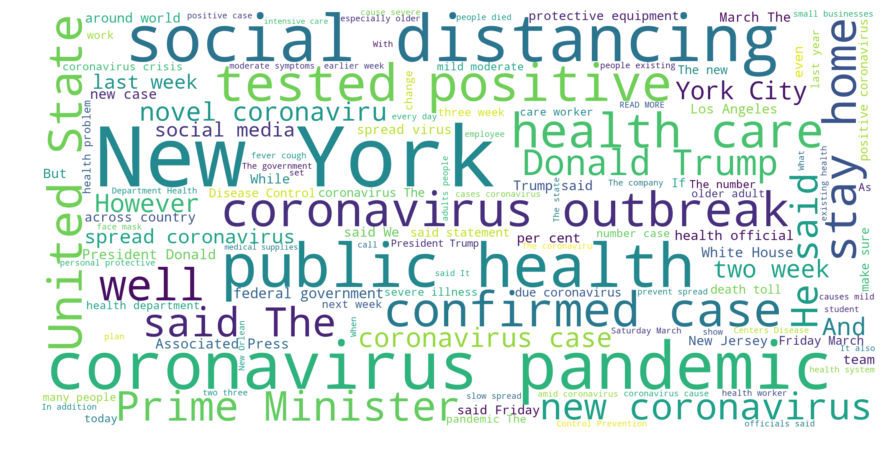

In [15]:
# vocabulary word cloud 2-gram 
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=18, max_words=1000, background_color="white").generate(' '.join(all_words))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [16]:
wordcloud.words_

{'New York': 1.0,
 'coronavirus pandemic': 0.5728357129947588,
 'social distancing': 0.5514639436110609,
 'public health': 0.4927254653894813,
 'tested positive': 0.4395897343213447,
 'confirmed case': 0.3827037773359841,
 'coronavirus outbreak': 0.3741641062714621,
 'health care': 0.37145309958431233,
 'United State': 0.3668443882161576,
 'stay home': 0.3487710103018254,
 'well': 0.32007952286282304,
 'Prime Minister': 0.30697632387493223,
 'said The': 0.30019880715705766,
 'new coronavirus': 0.24855412976685343,
 'He said': 0.2479215615398518,
 'Donald Trump': 0.24737936020242182,
 'coronavirus case': 0.24701789264413518,
 'novel coronaviru': 0.242002530272908,
 'However': 0.2368064341225375,
 'York City': 0.22935116573287548,
 'And': 0.22519428881257908,
 'two week': 0.22456172058557744,
 'spread coronavirus': 0.2224380986806434,
 'last week': 0.22207663112235676,
 'social media': 0.22058557744442436,
 'federal government': 0.2194559913247786,
 'Associated Press': 0.2057654075546719

In [19]:
all_text = nltk.Text(all_words)
all_text.similar('virus')

coronavirus pandemic disease people the cases said i outbreak state
crisis infection country patients march us it positive one time


In [20]:
all_text.collocation_list(10, 2)

[('New', 'York'),
 ('social', 'distancing'),
 ('United', 'States'),
 ('tested', 'positive'),
 ('Prime', 'Minister'),
 ('coronavirus', 'pandemic'),
 ('Los', 'Angeles'),
 ('Associated', 'Press'),
 ('Donald', 'Trump'),
 ('confirmed', 'cases')]

In [29]:
#Find contexts where the specified words appear; list most frequent common contexts first.
all_text.common_contexts(['York'], num=20)

new_city new_new new_state new_times new_gov new_the new_governor
new_area new_ap new_i new_parts new_washington new_probably
new_remained new_connecticut new_well new_cases new_plates new_said
new_harbor


In [30]:
all_text.concordance('York', width=50 , lines=20)

Displaying 20 of 22487 matches:
 That driver could New York really bad Or Chicago 
red Port Authority New York New Jersey local hospi
toric claims filed New York state million nationwi
crowded conditions New York City towns like Wilton
crowded conditions New York City towns like Wilton
crowded conditions New York City towns like Wilton
crowded conditions New York City towns like Wilton
 coronavirus cases New York state doubling every t
away Wilton People New York City constantly callin
virus particularly New York City game changer That
basis There people New York looking Connecticut fi
ituation If people New York like see Connecticut p
rtial law disappointed York Region residents stuck
ook page also included York Region residents One c
rtial law disappointed York Region residents stuck
crat Chuck Schumer New York wrestled days along Tr
rence Four Seasons New York With moving parts LED 
 recently traveled New York quarantined home All T
ntly returned trip New York The health district in

# Topic Modelling

In [17]:
from nltk.corpus import wordnet
# nltk.download('wordnet')
def prepare_text_for_lda(word):
    if word not in stopwordEn and word.isalpha():
        lemma = wordnet.morphy(word)
        if lemma is not None:
            return lemma
        else:
            return word

In [18]:
text_data = []
for t in tqdm(df['text']):
    tokens = []
    for w in word_tokenize(t):
        token = prepare_text_for_lda(w)
        if token is not None:
            tokens.append(token)
    text_data.append(tokens)

100%|██████████| 50665/50665 [09:52<00:00, 85.54it/s] 


In [26]:
with open('0328_text_data.pickle', 'wb') as handle:
    pickle.dump(text_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [27]:
import gensim
NUM_TOPICS = 12
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
# ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.024*"say" + 0.023*"test" + 0.020*"case" + 0.017*"The" + 0.014*"hospital"')
(1, '0.019*"The" + 0.013*"season" + 0.011*"player" + 0.011*"game" + 0.009*"team"')
(2, '0.021*"say" + 0.016*"school" + 0.015*"student" + 0.015*"child" + 0.010*"family"')
(3, '0.030*"I" + 0.012*"say" + 0.009*"get" + 0.008*"It" + 0.008*"people"')
(4, '0.016*"The" + 0.010*"business" + 0.008*"say" + 0.007*"need" + 0.007*"government"')
(5, '0.019*"de" + 0.014*"market" + 0.012*"The" + 0.010*"la" + 0.009*"price"')
(6, '0.016*"virus" + 0.010*"people" + 0.009*"say" + 0.009*"The" + 0.008*"coronavirus"')
(7, '0.012*"The" + 0.008*"help" + 0.008*"information" + 0.007*"use" + 0.006*"also"')
(8, '0.029*"Trump" + 0.026*"New" + 0.021*"York" + 0.020*"say" + 0.015*"state"')
(9, '0.019*"The" + 0.018*"say" + 0.015*"coronavirus" + 0.013*"death" + 0.013*"case"')
(10, '0.022*"say" + 0.012*"The" + 0.011*"order" + 0.011*"people" + 0.010*"close"')
(11, '0.015*"say" + 0.014*"The" + 0.012*"people" + 0.011*"government" + 0.009*"lockdo

In [28]:
# 5-word topics
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [25]:
# 3-word topics
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

# Compare one-week data

In [25]:
dates = [23,24,25,26,27,28,29]
word_dicts={}
word_dicts_2g={}
for d in dates:
    with open('./data_0323_29/news_words_dict_03{}.pickle'.format(d), 'rb') as handle:
        word_dicts[d] = pickle.load(handle)
    with open('./data_0323_29/news_words_dict_2G_03{}.pickle'.format(d), 'rb') as handle:
        word_dicts_2g[d] = pickle.load(handle)

In [26]:
dfs = [pd.DataFrame(word_dicts[d].most_common(100),columns=['Mar_{} '.format(d),'counts_{}'.format(d)]) for d in dates]
df_words_dict = pd.concat(dfs,axis=1)
df_words_dict.head(30)

,Mar_23,counts_23,Mar_24,counts_24,Mar_25,counts_25,Mar_26,counts_26,Mar_27,counts_27,Mar_28,counts_28,Mar_29,counts_29
0,The,412237,The,436974,The,461790,The,456218,The,429475,The,261725,The,155935
1,said,331274,said,372611,said,389607,said,361408,said,338101,said,233737,said,143592
2,coronavirus,211873,coronavirus,216363,coronavirus,230730,coronavirus,216494,coronavirus,210123,coronavirus,137857,I,89046
3,people,190915,people,206763,people,212956,I,202495,I,201845,I,134343,coronavirus,86931
4,I,172574,I,200275,I,211588,people,196859,people,187224,people,129219,people,86018
5,also,126276,also,132294,also,138323,also,135980,also,125199,also,77379,also,49132
6,March,123696,March,131355,March,132634,March,133666,March,121794,March,74528,We,44897
7,We,110066,We,122457,We,127816,We,122828,We,113629,We,69046,cases,44043
8,health,103600,health,113773,health,122685,would,113639,health,104224,health,68472,March,41475
9,would,102485,would,113352,would,119273,health,108259,would,96898,cases,66428,health,41438


In [27]:
dfs = [pd.DataFrame(word_dicts_2g[d].items(),columns=['Mar_{} '.format(d),'counts_{}'.format(d)]) for d in dates]
df_words_dict_2g = pd.concat(dfs,axis=1)
df_words_dict_2g.head(30)

,Mar_23,counts_23,Mar_24,counts_24,Mar_25,counts_25,Mar_26,counts_26,Mar_27,counts_27,Mar_28,counts_28,Mar_29,counts_29
0,social distancing,1.000000,New York,1.000000,New York,1.000000,New York,1.000000,New York,1.000000,New York,1.000000,New York,1.000000
1,New York,0.957765,coronavirus pandemic,0.976557,coronavirus pandemic,0.862509,coronavirus pandemic,0.900764,coronavirus pandemic,0.755615,coronavirus pandemic,0.596867,coronavirus pandemic,0.542174
2,coronavirus pandemic,0.910139,social distancing,0.955658,social distancing,0.788930,social distancing,0.840406,social distancing,0.685414,social distancing,0.579799,social distancing,0.498219
3,stay home,0.736645,public health,0.820213,public health,0.664148,public health,0.653717,public health,0.554921,public health,0.499023,tested positive,0.431584
4,public health,0.715977,stay home,0.737566,stay home,0.566476,last week,0.599333,tested positive,0.511608,tested positive,0.450394,Prime Minister,0.430506
5,last week,0.698469,last week,0.726228,last week,0.529405,coronavirus outbreak,0.563735,health care,0.495862,coronavirus outbreak,0.401277,public health,0.418416
6,tested positive,0.633521,coronavirus outbreak,0.635522,tested positive,0.510562,stay home,0.527331,United State,0.461126,confirmed case,0.389291,confirmed case,0.387816
7,coronavirus outbreak,0.618183,Prime Minister,0.626115,coronavirus outbreak,0.504747,United State,0.492400,Prime Minister,0.442765,health care,0.386685,stay home,0.363824
8,confirmed case,0.520420,health care,0.550271,health care,0.485831,health care,0.477921,coronavirus outbreak,0.426164,United State,0.384372,coronavirus outbreak,0.343440
9,Prime Minister,0.509420,United State,0.509944,United State,0.443264,tested positive,0.471196,stay home,0.391000,stay home,0.354602,United State,0.308060


In [30]:
df_words_dict_2g.iloc[:30,5:]

,counts_25,Mar_26,counts_26,Mar_27,counts_27,Mar_28,counts_28,Mar_29,counts_29
0,1.000000,New York,1.000000,New York,1.000000,New York,1.000000,New York,1.000000
1,0.862509,coronavirus pandemic,0.900764,coronavirus pandemic,0.755615,coronavirus pandemic,0.596867,coronavirus pandemic,0.542174
2,0.788930,social distancing,0.840406,social distancing,0.685414,social distancing,0.579799,social distancing,0.498219
3,0.664148,public health,0.653717,public health,0.554921,public health,0.499023,tested positive,0.431584
4,0.566476,last week,0.599333,tested positive,0.511608,tested positive,0.450394,Prime Minister,0.430506
5,0.529405,coronavirus outbreak,0.563735,health care,0.495862,coronavirus outbreak,0.401277,public health,0.418416
6,0.510562,stay home,0.527331,United State,0.461126,confirmed case,0.389291,confirmed case,0.387816
7,0.504747,United State,0.492400,Prime Minister,0.442765,health care,0.386685,stay home,0.363824
8,0.485831,health care,0.477921,coronavirus outbreak,0.426164,United State,0.384372,coronavirus outbreak,0.343440
9,0.443264,tested positive,0.471196,stay home,0.391000,stay home,0.354602,United State,0.308060


In [32]:
# Tweets data
tweets_word_dicts,tweets_word_dicts_2g,tweets_hashtags_dicts = {},{},{}
dates = [28,29]
for d in dates:
    with open('../IEEE_tweets/data_0323-29/tweets_words_dict_03{}.pickle'.format(d), 'rb') as handle:
            tweets_word_dicts[d] = pickle.load(handle)
    with open('../IEEE_tweets/data_0323-29/tweets_words_dict_2G_03{}.pickle'.format(d), 'rb') as handle:
            tweets_word_dicts_2g[d] = pickle.load(handle)
    with open('../IEEE_tweets/data_0323-29/tweets_hashtags_dict_03{}.pickle'.format(d), 'rb') as handle:
            tweets_hashtags_dicts[d] = pickle.load(handle)

In [33]:
dfs = [pd.DataFrame(tweets_word_dicts[d].most_common(100),columns=['Mar_{} '.format(d),'counts_{}'.format(d)]) for d in dates]
df_t_words_dict = pd.concat(dfs,axis=1)
df_t_words_dict.head(30)

,Mar_28,counts_28,Mar_29,counts_29
0,https,489236,https,194939
1,Corona,382456,corona,148128
2,corona,283833,Corona,129732
3,I,180425,I,70808
4,virus,164535,virus,60869
5,The,94141,The,45926
6,amp,89345,patients,45183
7,people,84624,Germany,43549
8,Virus,63473,plane,36117
9,lakh,57239,amp,34788


In [35]:
dfs = [pd.DataFrame(tweets_hashtags_dicts[d].most_common(100),columns=['Mar_{} '.format(d),'counts_{}'.format(d)]) for d in dates]
df_hashtags_dict = pd.concat(dfs,axis=1)
df_hashtags_dict.head(30)

,Mar_28,counts_28,Mar_29,counts_29
0,Corona,44886,Corona,16039
1,IndiaFightsCorona,24687,corona,4877
2,COVID19.,19384,IndiaFightsCorona,3718
3,StayHomeIndia,19160,coronavirus,3671
4,corona,15082,COVID19,3105
5,COVID19,14220,COVID19.,3025
6,coronavirus,12267,StayHomeIndia,2769
7,Wuhan,7856,Covid_19,2385
8,CoronaUpdate,6239,CoronaUpdate,2371
9,CoronaLockdown,5946,DSSFightsWithCorona,2114


In [38]:
dfs = [pd.DataFrame(tweets_word_dicts_2g[d].items(),columns=['Mar_{} '.format(d),'counts_{}'.format(d)]) for d in dates]
df_t_words_dict_2g = pd.concat(dfs,axis=1)
df_t_words_dict_2g.head(1000)

,Mar_28,counts_28,Mar_29,counts_29
0,corona viru,1.000000,corona viru,1.000000
1,fight Corona,0.195397,corona patient,0.272964
2,Due Corona,0.185455,patients Italy,0.264452
3,https http,0.180217,flying ICU,0.239179
4,https corona,0.155255,ICU plane,0.237311
...,...,...,...,...
995,Andhra Pradesh,0.005485,less month,0.006736
996,Lakhs To,0.005485,WHO guideline,0.006736
997,Corona narendramodi,0.005480,end Corona,0.006723
998,Full body,0.005475,FREE CORONA,0.006723
